In [1]:
import ROOT

Module libc not found.


Welcome to JupyROOT 6.30/09


In [2]:
ROOT.gSystem.Load('./RooMultiVarGaussian2e_cxx.so')

0

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from os.path import exists

import read_config_utils as cu

In [4]:
import sys
import time

import gc

In [5]:
#input_dir = 'output-files-bootstrap-test6b-6d'

#input_dir = 'bootstrap-simple-pdf-toy-study6b-2d-v1b'

#input_dir = 'output-files-bootstrap-test6b-2d-2a-100k'


#input_dir = 'bootstrap-toy-study6b-2d-4c'

#input_dir = 'bootstrap-simple-pdf-toy-study6b-2d-4c'



#input_dir = 'freshtoys-toy-study6b-2d-4c'

#input_dir = 'freshtoys-simple-pdf-toy-study6b-2d-4c'



#input_dir = 'freshtoys-toy-study6b-2d-4c-save-model'

#input_dir = 'freshtoys-toy-study6b-2d-4c-save-model/freshmc-02'




#input_dir = 'bootstrap-toy-study6b-1d-1a'
#input_dir = 'bootstrap-toy-study6b-1d-1a-badres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-goodres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-verygoodres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-perfect'#



#input_dir = 'fit-pdf-toy-study-2d-1a'

#input_dir = 'fit-pdf-toy-study-1d-1a'

#input_dir = 'hist-pdf-toy-study-1d-1a'

#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution-5k-toys'

#input_dir = 'hist-pdf-toy-study-1d-1a-badres'

#input_dir = 'hist-pdf-toy-study-1d-1b'

#input_dir = 'bootstrap-toy-study8a-1d-1d'

#input_dir = 'bootstrap-toy-study8a-1d-1d-gpu0'


#input_dir = 'hist-pdf-toy-study-1d-2a'

#input_dir = 'bootstrap-toy-study8a-1d-2a'


#input_dir = 'hist-pdf-toy-study-1d-2a-discretized-data-perfect'


input_dir = 'hist-pdf-toy-study-1d-3c'


#---


points_file = 'train-and-true-samples.npy'





In [6]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [7]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)



 Number of feature dimensions: 1




In [8]:
with open( '%s/config-pars.npy' % input_dir, 'rb') as f :
    train_mu = np.load(f, allow_pickle=True )
    train_rho = np.load(f, allow_pickle=True)
    train_sig = np.load(f, allow_pickle=True)    
    true_mu = np.load(f, allow_pickle=True )
    true_rho = np.load(f, allow_pickle=True)
    true_sig = np.load(f, allow_pickle=True)  
    resolution = np.load(f, allow_pickle=True)

In [9]:
with open('%s/%s' % (input_dir, points_file),'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)


In [10]:
n_samples = 0

for fi in range(1000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 265 bootstrap samples.




## Read in the main OmniFold ouput for the fake data and fit it before doing the bootstraps

In [11]:
fname = '%s/omnifold-output-weights.npy' % (input_dir)
#fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, 0)  

print('\n\n Reading in %s for weights in test fit.\n\n' % fname)
with open(fname,'rb') as f :
    sample_weights = np.load(f)



 Reading in hist-pdf-toy-study-1d-3c/omnifold-output-weights.npy for weights in test fit.




In [12]:

nmcevts = len(train_pts)

print( "train_pts shape:  %s" % str(train_pts.shape))
print( "weights:  %s" % str(sample_weights.shape))

print( "number of MC events: %d" % nmcevts)

train_pts shape:  (100000, 1)
weights:  (100000,)
number of MC events: 100000


In [13]:


true_cov  = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d : diagonal  %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
   

   0,  0 : diagonal    0.8100


## Read in the simple calculation results to set the parameter limits

In [14]:
with open( '%s/simple-calc-results.npy' % input_dir, 'rb') as f :
    sc_ave_mean_val = np.load(f, allow_pickle=True )
    sc_ave_mean_rms = np.load(f, allow_pickle=True)
    sc_ave_cov_val  = np.load(f, allow_pickle=True)    
    sc_ave_cov_rms  = np.load(f, allow_pickle=True )



In [15]:
sc_ave_cov_val

array([[0.83128148]])

In [16]:
print('\n\n')
print('  Simple direct calculation results from the bootstrap samples.\n')

for fi in range(ndim) :
    print('  feature %d  mean:   %8.4f  (true %8.4f) RMS  %8.4f'
         % (fi, sc_ave_mean_val[fi], true_mu[fi], sc_ave_mean_rms[fi]) )
    
print('\n')

for i in range(ndim) :
    for j in range(i,ndim) :
        print('   %d, %d  cov:   %8.4f  (true %8.4f) RMS  %8.4f'
              % ( i, j, sc_ave_cov_val[i][j], true_cov[i,j], sc_ave_cov_rms[i][j]) )

print('\n\n')




  Simple direct calculation results from the bootstrap samples.

  feature 0  mean:     0.1999  (true   0.2000) RMS    0.0116


   0, 0  cov:     0.8313  (true   0.8100) RMS    0.0178





In [17]:
width_factor_mean = 10
width_factor_cov = 10

###  Do it this way to keep all the RooRealVars in memory in separate objects (different elements in the dictionary).

In [18]:
covdict = {}


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        startval = sc_ave_cov_val[i][j]
        minval = sc_ave_cov_val[i][j] - width_factor_cov * sc_ave_cov_rms[i][j]
        maxval = sc_ave_cov_val[i][j] + width_factor_cov * sc_ave_cov_rms[i][j]   
        print(' parameter %s  min %8.4f, max %8.4f' % (vname, minval, maxval))
        if ( i == j ) :
            ######covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), true_cov[i][j], 0.02, 2.0 )           
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        else :
            ######covdict[vname] =   ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), true_cov[i][j], -1.1, 1.1 ) 
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        covdict[vname].Print()
        


 parameter cov00  min   0.6534, max   1.0092
RooRealVar::cov00 = 0.831281  L(0.653365 - 1.0092) 


In [19]:
covRAL = ROOT.RooArgList()


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        covRAL.add( covdict[vname] )


In [20]:
ralind = 0
for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        print( "  %d, %d :  %2d :  %s  %8.3f" % (i,j, ralind, covRAL.at(ralind).GetName(), covRAL.at(ralind).getVal() )) 
        ralind = ralind + 1

  0, 0 :   0 :  cov00     0.831


### The Dict keeps the variables defined in memory

In [21]:
xDict = {}
muDict = {}

xVec = ROOT.RooArgList()
muVec = ROOT.RooArgList()


for i in range(ndim) :
    vname = "x%d" % i
    xDict[vname] = ROOT.RooRealVar( vname, vname, 0., -10., 10. )
    xVec.add( xDict[vname] )
    vname = "mu_x%d" % i
    startval = sc_ave_mean_val[i]
    minval = sc_ave_mean_val[i] - width_factor_mean * sc_ave_mean_rms[i]
    maxval = sc_ave_mean_val[i] + width_factor_mean * sc_ave_mean_rms[i]
    print('  feature %d  mean :  min %8.4f, max %8.4f' % (i, minval, maxval))
    ##########muDict[vname] =  ROOT.RooRealVar( vname, vname, true_mu[i], -2., 2. )
    muDict[vname] =  ROOT.RooRealVar( vname, vname, startval, minval, maxval )
    muDict[vname].Print()
    muVec.add( muDict[vname] )
    
    
weight = ROOT.RooRealVar("weight","weight", 0., 100. )

  feature 0  mean :  min   0.0841, max   0.3157
RooRealVar::mu_x0 = 0.199906  L(0.0840641 - 0.315748) 


In [22]:
rmvg = ROOT.RooMultiVarGaussian2e("rmvg","rmvg", xVec, muVec, covRAL )

  Setting _prevCovVals[0] to 0.831281
 i,j = 0,0

1x1 matrix is as follows

     |      0    |
------------------
   0 |     0.8313 


1x1 matrix is as follows

     |      0    |
------------------
   0 |          0 



 cov inverse.

1x1 matrix is as follows

     |      0    |
------------------
   0 |      1.203 



 Check of inverse

1x1 matrix is as follows

     |      0    |
------------------
   0 |          1 



In [23]:
xVec.Print("V")

  1) RooRealVar:: x0 = 0


In [24]:
data_test = ROOT.RooDataSet( "data_test", "data_test", ROOT.RooArgSet(xVec, weight) , ROOT.RooFit.WeightVar("weight"))
ROOT.SetOwnership( data_test, True )

In [25]:
%%time

for i in range( len(sample_weights) ) :
    if i % (len(sample_weights)/100 ) == 0 : print( " %9d / %9d  (%6.0f)%%" % (i, len(sample_weights), 100*i/len(sample_weights)))
    for j in range( ndim ) :
        xVec[j].setVal( train_pts[i,j] )
    weight.setVal( sample_weights[i])
    data_test.add( ROOT.RooArgSet(xVec, weight), weight.getVal() )

         0 /    100000  (     0)%
      1000 /    100000  (     1)%
      2000 /    100000  (     2)%
      3000 /    100000  (     3)%
      4000 /    100000  (     4)%
      5000 /    100000  (     5)%
      6000 /    100000  (     6)%
      7000 /    100000  (     7)%
      8000 /    100000  (     8)%
      9000 /    100000  (     9)%
     10000 /    100000  (    10)%
     11000 /    100000  (    11)%
     12000 /    100000  (    12)%
     13000 /    100000  (    13)%
     14000 /    100000  (    14)%
     15000 /    100000  (    15)%
     16000 /    100000  (    16)%
     17000 /    100000  (    17)%
     18000 /    100000  (    18)%
     19000 /    100000  (    19)%
     20000 /    100000  (    20)%
     21000 /    100000  (    21)%
     22000 /    100000  (    22)%
     23000 /    100000  (    23)%
     24000 /    100000  (    24)%
     25000 /    100000  (    25)%
     26000 /    100000  (    26)%
     27000 /    100000  (    27)%
     28000 /    100000  (    28)%
     29000 /  

In [26]:
data_test

In [27]:
data_test.Print("V")

DataStore data_test (data_test)
  Contains 100000 entries
  Observables: 
    1)  x0 = 0.261447  L(-10 - 10)  "x0"
  Dataset variable "weight" is interpreted as the event weight


In [28]:
data_test.get(0).Print("V")

  1) RooRealVar:: x0 = -0.907999


In [29]:

for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        if ( i == j ) : continue
        vname = "cov%d%d" % (i,j)
        #########covRAL.find(vname).setConstant()

In [30]:
covRAL.Print("V")

  1) RooRealVar:: cov00 = 0.831281


In [31]:
covRAL.find("cov00").isConstant()

False

In [32]:
%%time

rfr = rmvg.fitTo( data_test, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
ROOT.SetOwnership( rfr, True )


CPU times: user 125 ms, sys: 246 ms, total: 370 ms
Wall time: 759 ms
  copy constructor, Setting _prevCovVals[0] to 0.831281
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 28 remote server process.
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
Minuit2Minimizer: Minimize with max-calls 1000 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 13090.9244483165294
Edm   = 0.000119702247618464551
Nfcn  = 38
cov00	  = 0.806742	 +/-  0.0114131	(limited)
mu_x0	  = 0.21305	 +/-  0.00898078	(limited)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization


Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       14016.48521 Edm =  -9.770142755e-07 NCalls =      9
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 13091.99963
  Edm           : 1.076081008
  Internal parameters:	[    -0.1421758959                0]	
  Internal gradient  :	[    -0.9087213031     -18.89623645]	
  Internal covariance matrix:
[[   0.0083846015              0]
 [              0    0.012035252]]]
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 13091.99963
  Edm           : 1.076081008
  Internal parameters:	[    -0.1421758959                0]	
  Internal gradient  :	[    -0.9087213031     -18.89623645]	
  Internal covariance matrix:
[[   0.0083846015              0]
 [              0    0.012035252]]]
Info in 

In [33]:
covRAL.Print("V")

  1) RooRealVar:: cov00 = 0.806742 +/- 0.011413


In [34]:
for i in range(ndim) :
    fit_mean = muDict["mu_x%d" % i].getVal()
    fit_mean_err = muDict["mu_x%d" % i].getError()
    print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
          (i, fit_mean, true_mu[i], fit_mean_err, (fit_mean-true_mu[i]), (fit_mean-true_mu[i])/fit_mean_err) )

print("\n")

for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        fit_cov = covdict["cov%d%d" % (i,j)].getVal()
        fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
        print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i,j, fit_cov, true_cov[i][j], fit_cov_err, 
               (fit_cov-true_cov[i][j]), (fit_cov-true_cov[i][j])/fit_cov_err)  )

   0 :  mu =   0.2131   (true   0.2000) err   0.0090  diff   0.0131   diff/err   1.45


  0,  0 :  cov    0.8067  (true   0.8100) err   0.0114  diff  -0.0033   diff/err  -0.29


In [35]:

del data_test
del rfr
gc.collect()

0

In [36]:
n_samples = np.min( [n_samples,50] )

In [37]:
fit_results_mean_val = np.zeros( shape=(ndim, n_samples ) )
fit_results_mean_err = np.zeros( shape=(ndim, n_samples ) )
fit_results_cov_val = np.zeros( shape=(ndim, ndim, n_samples ) )
fit_results_cov_err = np.zeros( shape=(ndim, ndim, n_samples ) )

In [38]:
%%time

#### TESTING
###n_samples = 1

for bi in range( n_samples ) :
    
    print("\n\n --- bootstrap sample %3d" % bi, flush=True )
    sys.stdout.flush()
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, bi)    
    print('Reading weights file : %s' % fname )
    
    with open(fname,'rb') as f :
        bootstrap_sample_weights = np.load(f)
        
    data_weighted = ROOT.RooDataSet("data_weighted","data_weighted", ROOT.RooArgSet(xVec,weight), ROOT.RooFit.WeightVar("weight"))
    ROOT.SetOwnership( data_weighted, True )
    
    print('Filling RooDataSet with %d events' % len(bootstrap_sample_weights) )
    for i in range( len(bootstrap_sample_weights) ) :
        for j in range( ndim ) :
            xVec[j].setVal( train_pts[i,j] )
        weight.setVal( bootstrap_sample_weights[i] )
        data_weighted.add( ROOT.RooArgSet(xVec,weight), weight.getVal() )
        
    print("  Running fit...")
    sys.stdout.flush()
        
    rfr = rmvg.fitTo( data_weighted, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
    ROOT.SetOwnership( rfr, True )
    
    for i in range(ndim) :
        fit_mean = muDict["mu_x%d" % i].getVal()
        fit_mean_err = muDict["mu_x%d" % i].getError()
        fit_results_mean_val[i,bi] = fit_mean
        fit_results_mean_err[i,bi] = fit_mean_err
        print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i, fit_mean, true_mu[i], fit_mean_err, (fit_mean-true_mu[i]), (fit_mean-true_mu[i])/fit_mean_err) )

    print("\n")

    for i in range(ndim) :
        for j in range(ndim) :
            if ( j < i ) : continue
            fit_cov = covdict["cov%d%d" % (i,j)].getVal()
            fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
            fit_results_cov_val[i,j,bi] = fit_cov
            fit_results_cov_err[i,j,bi] = fit_cov_err
            print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
                  (i,j, fit_cov, true_cov[i][j], fit_cov_err, 
                   (fit_cov-true_cov[i][j]), (fit_cov-true_cov[i][j])/fit_cov_err)  )
    
    print("Cleaning up.")
    del bootstrap_sample_weights
    del data_weighted
    del rfr
    gc.collect()
    #print("Pausing for 3 seconds.")
    #time.sleep(3)        
        
        



 --- bootstrap sample   0
Reading weights file : hist-pdf-toy-study-1d-3c/bootstrap-weights-000.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1873   (true   0.2000) err   0.0090  diff  -0.0127   diff/err  -1.41


  0,  0 :  cov    0.8120  (true   0.8100) err   0.0115  diff   0.0020   diff/err   0.18
Cleaning up.


 --- bootstrap sample   1
Reading weights file : hist-pdf-toy-study-1d-3c/bootstrap-weights-001.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2170   (true   0.2000) err   0.0092  diff   0.0170   diff/err   1.85


  0,  0 :  cov    0.8411  (true   0.8100) err   0.0119  diff   0.0311   diff/err   2.61
Cleaning up.


 --- bootstrap sample   2
Reading weights file : hist-pdf-toy-study-1d-3c/bootstrap-weights-002.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1843   (true   0.2000) err   0.0092  diff  -0.0157   diff/err  -1.71


  0,  0 :  cov    0.8405  (true   0.8100) err   0.0119  diff   



 --- bootstrap sample  24
Reading weights file : hist-pdf-toy-study-1d-3c/bootstrap-weights-024.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2089   (true   0.2000) err   0.0093  diff   0.0089   diff/err   0.96


  0,  0 :  cov    0.8584  (true   0.8100) err   0.0121  diff   0.0484   diff/err   3.98
Cleaning up.


 --- bootstrap sample  25
Reading weights file : hist-pdf-toy-study-1d-3c/bootstrap-weights-025.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2012   (true   0.2000) err   0.0092  diff   0.0012   diff/err   0.13


  0,  0 :  cov    0.8404  (true   0.8100) err   0.0119  diff   0.0304   diff/err   2.56
Cleaning up.


 --- bootstrap sample  26
Reading weights file : hist-pdf-toy-study-1d-3c/bootstrap-weights-026.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2255   (true   0.2000) err   0.0090  diff   0.0255   diff/err   2.83


  0,  0 :  cov    0.8160  (true   0.8100) err   0.0115  diff   

   0 :  mu =   0.2072   (true   0.2000) err   0.0091  diff   0.0072   diff/err   0.79


  0,  0 :  cov    0.8313  (true   0.8100) err   0.0118  diff   0.0213   diff/err   1.81
Cleaning up.


 --- bootstrap sample  48
Reading weights file : hist-pdf-toy-study-1d-3c/bootstrap-weights-048.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1906   (true   0.2000) err   0.0092  diff  -0.0094   diff/err  -1.02


  0,  0 :  cov    0.8471  (true   0.8100) err   0.0120  diff   0.0371   diff/err   3.09
Cleaning up.


 --- bootstrap sample  49
Reading weights file : hist-pdf-toy-study-1d-3c/bootstrap-weights-049.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2038   (true   0.2000) err   0.0091  diff   0.0038   diff/err   0.42


  0,  0 :  cov    0.8334  (true   0.8100) err   0.0118  diff   0.0234   diff/err   1.98
Cleaning up.
CPU times: user 26 s, sys: 12.3 s, total: 38.4 s
Wall time: 57.3 s
  copy constructor, Setting _prevCovVals[0] to 0.806

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       14056.01311 Edm =  -1.536701538e-07 NCalls =      9
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 13132.22407
  Edm           : 4.175077963
  Internal parameters:	[    -0.1048159417     0.1137104803]	
  Internal gradient  :	[   -0.02631849431      36.39085751]	
  Internal covariance matrix:
[[   0.0084505305              0]
 [              0    0.012610719]]]
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 13132.22407
  Edm           : 4.175077963
  Internal parameters:	[    -0.1048159417     0.1137104803]	
  Internal gradient  :	[   -0.02631849431      36.39085751]	
  Internal covariance matrix:
[[   0.0084505305              0]
 [              0    0.012610719]]]
Info in 

In [39]:
with open( '%s/fit-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, fit_results_mean_val )
    np.save( f, fit_results_mean_err )
    np.save( f, fit_results_cov_val )
    np.save( f, fit_results_cov_err )

<function matplotlib.pyplot.show(close=None, block=None)>

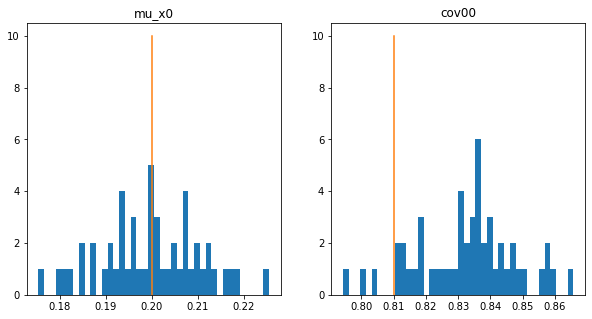

In [40]:
fig,ax = plt.subplots( ndim, 2, figsize=(10,5*ndim))

hbins=40

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    
    thisax.hist( fit_results_mean_val[i,:], bins=hbins)
    thisax.plot( [true_mu[i], true_mu[i]], [0,10])
    thisax.set_title( 'mu_x%d' % i )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    
    thisax.hist( fit_results_cov_val[i,i,:], bins=hbins)
    thisax.plot( [true_sig[i]*true_sig[i], true_sig[i]*true_sig[i]], [0,10])
    thisax.set_title( 'cov%d%d' % (i,i) )

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

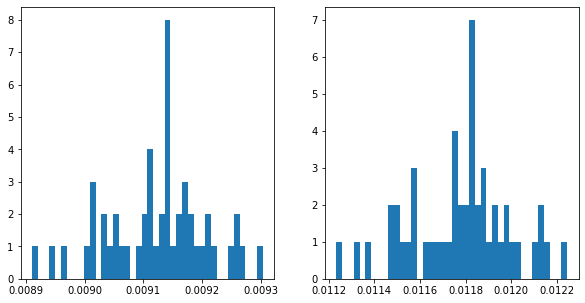

In [41]:
fig,ax = plt.subplots( ndim, 2, figsize=(10,5*ndim))

hbins=40

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    
    thisax.hist( fit_results_mean_err[i,:], bins=hbins)
    #thisax.plot( [true_mu[i], true_mu[i]], [0,10])
    #thisax.set_title( 'mu_x%d' % i )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    
    thisax.hist( fit_results_cov_err[i,i,:], bins=hbins)
    #thisax.plot( [true_sig[i]*true_sig[i], true_sig[i]*true_sig[i]], [0,10])
    #thisax.set_title( 'cov%d%d' % (i,i) )

plt.show

In [42]:
toy_fits_mu_rms = np.sqrt(np.var(fit_results_mean_val))
toy_fits_sig2_rms = np.sqrt(np.var(fit_results_cov_val))
toy_fits_mu_err_ave = np.average( fit_results_mean_err )
toy_fits_sig2_err_ave = np.average( fit_results_cov_err )

toy_fits_mu_ave = np.average( fit_results_mean_val )
toy_fits_sig2_ave = np.average( fit_results_cov_val )

print('\n\n')

print('  toy fits mu   ave. val  %7.4f,  true %7.4f' % (toy_fits_mu_ave, true_mu[0]))
print('  toy fits sig2 ave. val  %7.4f,  true %7.4f' % (toy_fits_sig2_ave, np.square(true_sig[0])))


print('\n\n')
print('  toy fits mu   RMS:  %7.4f,  ave fit err %7.4f' % (toy_fits_mu_rms, toy_fits_mu_err_ave))
print('  toy fits sig2 RMS:  %7.4f,  ave fit err %7.4f' % (toy_fits_sig2_rms, toy_fits_sig2_err_ave))
print('\n\n')





  toy fits mu   ave. val   0.1998,  true  0.2000
  toy fits sig2 ave. val   0.8327,  true  0.8100



  toy fits mu   RMS:   0.0108,  ave fit err  0.0091
  toy fits sig2 RMS:   0.0154,  ave fit err  0.0118



